In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('data/MNIST_train.csv', header = None)
Y_train = data.iloc[:, 0]
X_train = data.iloc[:, 1:]

In [4]:
from sklearn.decomposition import TruncatedSVD

In [19]:
from knn.knn_fast import KNNClassifierFast, majority, accuracy
import numba
import itertools
import numba
import threading
import queue
import numpy as np
from scipy.spatial.distance import cdist


In [18]:
class M(object):
    def __init__(self, p: float = 2.):
        """
        """
        self.p = p
        self.Y = None
        self.X = None
        self.predicted_labels = None
        self.loocv_labels = None
        self.loocv_accuracy = None
        
    def fit(self, X: np.ndarray, Y: np.array):
        """
        """
        # get initial data that is base for our further decision
        # training data feature space
        self.X = X
        #  training data label space
        self.Y = Y
        
        return self

        
    def minkowski_helper(self, q: queue.Queue, N, result):
        """
        Helper function to calculate minkowski distance. It picks a coordinate from the queue
        and it saves the result in the result matrix.
        """
        while True:
            task = q.get()

            i = task[0]
            prod = task[1]

            x = i // N
            y = i % N

            if (x == y):
                q.task_done()
                continue

            elif (x > y):
                q.task_done()
                continue

            m = minkowski(prod[0], prod[1], self.p)
            result[x, y] = m
            result[y, x] = m
            
            q.task_done()
        
    
    def compute_minkowski_distance(self, XA, XB, p, nr_of_threads):
        """
        
        """
        XA = np.asarray(XA)
        XB = np.asarray(XB)

        N = XB.shape[0]

        result = np.zeros([N, N])
        
        prod = list(itertools.product(XA, XA))

        q = queue.Queue()

        for i in range(len(prod)):
            q.put((i, prod[i]))

        for i in range(nr_of_threads):
            worker = threading.Thread(target=self.minkowski_helper, args=(q, N, result), daemon=True)
            worker.start()


        q.join()

        return result

    @staticmethod
    @numba.njit(parallel=True, fastmath=True)  #('(float64[:, :, :], uint64)', parallel=True, fastmath=True)
    def minkowski_distance(X, p):
        """
        Function that computes the minkowski distance between X and X.
        The numba decorators makes sure that this code is compiled to machine code.
        """
        N = X.shape[0]
        X = np.asarray(X)
        result = np.empty(shape=(N, N), dtype=np.float32)
        for i in numba.prange(N):
            for j in numba.prange(N):
                if (j > i):
                    continue

                elif (i == j):
                    result[i,j] = 0
                    continue

                u_v = X[i].astype(np.float32) - X[j].astype(np.float32)
                norm = np.linalg.norm(u_v, ord=p)
                result[i, j] = norm
                result[j, i] = norm


        return result
    
    def calculate_distance(self):
        # get distances between input X and train X
        try:
            distances = self.minkowski_distance(self.X.to_numpy(), self.p)
        except:
            distances = self.minkowski_distance(self.X, self.p)

        return distances

In [20]:
def calculate_loocv(distances,X,Y):
    results = []
    for k in np.arange(1,21):
        # get distances between input X and train X
        # get auxiliary label matrix
        labels = np.tile(Y, (X.shape[0], 1))
        supermatrix = np.zeros((X.shape[0], k, 2))
        # sort distances
        sorted_points_indices = np.apply_along_axis(np.argsort, 1, distances)[:, 1:k+1]
        supermatrix[:, :, 0] = distances[np.arange(sorted_points_indices.shape[0])[:, None], sorted_points_indices]
        # sort labels according to indices
        supermatrix[:, :, 1] = labels[np.arange(sorted_points_indices.shape[0])[:, None], sorted_points_indices]

        # predict labels using rule with tie-breaking extension
        loocv_labels = np.apply_along_axis(majority, 1,
                                                        supermatrix.reshape((supermatrix.shape[0],
                                                                             2 * supermatrix.shape[1]),
                                                                            order='F'), k=k)
        loocv_loss = 1 - accuracy(Y, loocv_labels)
        results.append(loocv_loss)
    return results

In [5]:
dimensions = [50, 100, 150, 200, 300, 400, 500, 600, 650, 700]

In [6]:
df = pd.DataFrame()

In [23]:
for dim in dimensions:
    print(f'{dim} is started')
    X = TruncatedSVD(n_components=dim).fit_transform(X_train.iloc[:20000,:])
    distances = M(p=14.).fit(X, Y_train[:20000]).calculate_distance()
    results = calculate_loocv(distances, X, Y_train[:20000])
    for k in range(20):
        df = df.append({'k': k+1, 'p': 14., 'loss': results[k], 'dim': dim}, ignore_index = True)
    df.to_csv('questionG.csv')
    

50 is started
100 is started
150 is started
200 is started
300 is started
400 is started
500 is started
600 is started
650 is started
700 is started


In [24]:
df.shape

(200, 4)

In [33]:
losses = df[df.dim < 400].pivot('dim', 'k', 'loss').values

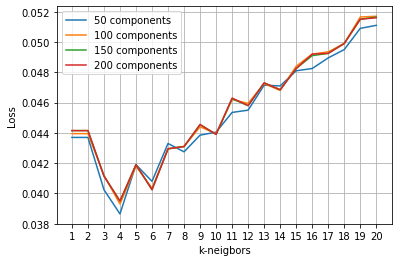

In [37]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, 21), losses[0], label = "50 components")
plt.plot(np.arange(1, 21), losses[1], label = "100 components")

plt.plot(np.arange(1, 21), losses[2], label = "150 components")
plt.plot(np.arange(1, 21), losses[3], label = "200 components")


plt.xlabel('k-neigbors')
# Set the y axis label of the current axis.
plt.ylabel('Loss')
# Set a title of the current axes.
plt.xticks(np.arange(1, 21))
plt.grid()
# show a legend on the plot
plt.legend()
# Display a figure.

plt.show()